In [17]:
import tensorflow as tf
from tensorflow.keras import losses , metrics , applications ,layers  , models , callbacks , optimizers 
tf.keras.backend.set_image_data_format('channels_last')

import numpy as np
import pandas as pd

import cv2
from PIL import Image, ImageEnhance

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sn

import os , shutil
from shutil import copyfile

from tqdm import tqdm
from pprint import pprint
import  gc

import albumentations as A
import io

rs = 42
from collections import Counter

In [18]:
def display_images(List = None, Labels = None, size = 2,cmap = 'jet',grid=None , scaling =['unit','minmax'][0]):
    try:
        if(List!=None):
            n = len(List)
            
            if(grid==None):
                grid = (1,n)
                
            plt.figure(figsize = (size * grid[1], size*grid[0]))
            for i in range(n):
                plt.subplot(grid[0],grid[1],i+1)

                img  = List[i]
                img = np.array(img,dtype = np.float32)
                
                if(np.max(img)>1):
                    if(scaling == 'unit'):
                        # print('unit rescaling image')
                        img = img/255
                    else:
                        # print('min max rescaling image')
                        img = (img - img.min())/(img.max() - img.min())
                plt.imshow(img ,cmap = cmap)
                plt.axis('off')
                if(Labels != None):
                    plt.title(Labels[i],color = 'cyan')
            plt.show()
            
    except Exception as e:
        print('Error :',e)
        

In [134]:
configuration = {
    'classes' : ['cat','dog'],
    'shape' : (128,128,3),
    'activation' : 'relu',
    'n_class':2,
    'n_epoch':80,
    'lr': 0.005,
    'batch_size':16,
}

## Getting The Data

In [20]:
os.environ['KAGGLE_USERNAME'] = 'prajwalsharma123'
os.environ['KAGGLE_KEY']='6719f9750ed948ff6d82400eab62fe8c'

In [21]:
!kaggle competitions download -c dogs-vs-cats

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


 97%|███████████████████████████████████████▌ | 784M/812M [00:02<00:00, 278MB/s]
100%|█████████████████████████████████████████| 812M/812M [00:03<00:00, 281MB/s]


In [22]:
import zipfile
def Unzip_To_Folder(zip_path, dest_path ,remove_zip_path = True,remove_dest_path = True):     
    if(remove_dest_path):
        try:
            shutil.rmtree(dest_path)
        except Exception as e:
            print(e)
            os.makedirs(dest_path)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            zip_file.extractall(dest_path)
        if(remove_zip_path):
            os.remove(zip_path) # remove zip file
        print("Unziping Completed")
    except Exception as e:
        print(e)

In [23]:
zip_path = 'dogs-vs-cats.zip'
data_path = 'datasets/DVC/'
Unzip_To_Folder(zip_path,data_path,True,True)

Unziping Completed


In [24]:
zip_path = data_path + 'train.zip'
Unzip_To_Folder(zip_path,data_path,True,False)

Unziping Completed


In [25]:
os.remove(data_path + 'test1.zip')
os.remove(data_path + 'sampleSubmission.csv')

In [26]:
train_path = data_path + 'train/'
dirs = os.listdir( train_path)
for im_path in dirs:
    shutil.move(train_path + im_path , data_path)
shutil.rmtree(train_path)

## Data Visualisation

In [27]:
data_path = 'datasets/DVC/'

In [28]:
images_path = os.listdir(data_path)
images_path[:5]

['dog.10057.jpg',
 'dog.6306.jpg',
 'dog.5118.jpg',
 'cat.8169.jpg',
 'cat.5131.jpg']

In [29]:
images_path = [data_path + im_path for im_path in os.listdir(data_path)]
images_label = [0 if 'cat' in im_path  else 1 for im_path in images_path]
Counter(images_label)

Counter({1: 12500, 0: 12500})

In [30]:
Data = pd.DataFrame({'paths':images_path,'labels':images_label})
Data.sample(5)

,paths,labels
6807,datasets/DVC/cat.5004.jpg,0
11793,datasets/DVC/cat.686.jpg,0
2618,datasets/DVC/cat.9249.jpg,0
4288,datasets/DVC/cat.8203.jpg,0
20486,datasets/DVC/dog.7415.jpg,1


In [31]:
classes = configuration['classes']
def Show_images(num = 5 ,size=3):
    try:
        for i,class_ in enumerate(classes):
            images_path = Data[Data.labels == i].sample(num).paths.values
            images = []
            for img_path in images_path:
                image = Image.open(img_path)
                images.append(image)
            print(class_)
            display_images(images ,size = size ,grid = (1,num))
    except Exception as e:
        print(e)

cat


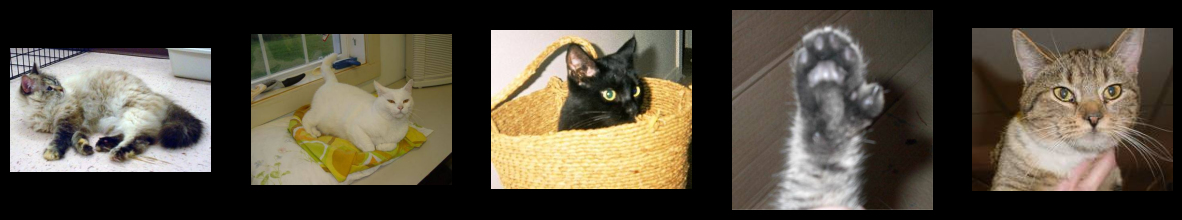

dog


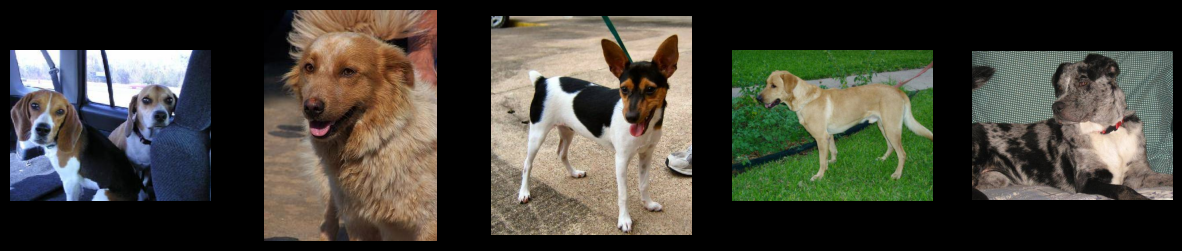

In [32]:
Show_images()

In [33]:
def get_size():
    Set = set()
    try:
        for im_path in tqdm(Data.paths):
            if('.' in im_path):
                image = Image.open(im_path)            
                Set.add(np.shape(image))            
    except Exception as e:
        print(e)
        
    return np.array(list(Set))

In [34]:
sizes = get_size()
sizes = pd.DataFrame(sizes)
sizes.describe()

100%|██████████| 25000/25000 [00:28<00:00, 885.90it/s]


,0,1,2
count,8513.000000,8513.000000,8513.0
mean,320.668624,325.723717,3.0
std,108.379950,107.046504,0.0
min,32.000000,42.000000,3.0
25%,240.000000,249.000000,3.0
50%,320.000000,325.000000,3.0
75%,402.000000,406.000000,3.0
max,768.000000,1050.000000,3.0


In [36]:
del sizes

## Load Data

In [37]:
# get X and Y
shape = configuration['shape']
def get_X_Y():
    X = []
    Y = []
    try:
        for im_path,label in tqdm(Data.values):
            if('.' in im_path):
                image = Image.open(im_path)  
                image = image.resize(shape[:2])
                X.append(np.array(image,dtype ='float64'))
                Y.append(label)
    except Exception as e:
        print(e)
    return np.array(X),np.array(Y)
X,Y = get_X_Y()

100%|██████████| 25000/25000 [01:13<00:00, 339.20it/s]


In [38]:
from sklearn.model_selection import train_test_split 
X_train ,X_test ,Y_train ,Y_test = train_test_split( X,Y,
                                                    test_size = 0.2,
                                                    random_state = rs,
                                                    stratify = Y )

X_train ,X_val ,Y_train ,Y_val = train_test_split( X_train,Y_train,
                                                    test_size = 0.1,
                                                    random_state = rs,
                                                    stratify = Y_train )

print(X_train.shape,X_test.shape,X_val.shape,Y_train.shape,Y_test.shape,Y_val.shape)
Counter(Y_train) , Counter(Y_test), Counter(Y_val)

(18000, 128, 128, 3) (5000, 128, 128, 3) (2000, 128, 128, 3) (18000,) (5000,) (2000,)


(Counter({0: 9000, 1: 9000}),
 Counter({1: 2500, 0: 2500}),
 Counter({0: 1000, 1: 1000}))

In [39]:
del X,Y

In [40]:
from tensorflow.data import Dataset
train_Data = Dataset.from_tensor_slices((X_train,Y_train))
val_Data = Dataset.from_tensor_slices((X_val,Y_val))

train_Data = (train_Data
              .batch(configuration['batch_size'],drop_remainder = True)
              .prefetch(tf.data.AUTOTUNE)
             )
val_Data = (val_Data
            .batch(configuration['batch_size'],drop_remainder = True)
            .prefetch(tf.data.AUTOTUNE)
           )
train_Data,val_Data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(16,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(16,), dtype=tf.int64, name=None))>)

In [41]:
del X_train,Y_train,X_val,Y_val

## Building Model

In [42]:
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,MaxPool2D,Activation
from tensorflow.keras.layers import BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.layers import RandomFlip , RandomContrast ,RandomZoom,RandomRotation
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetV2B0

In [49]:
def get_Augment(x_shape):
    fn_input = Input(x_shape)
    x = RandomContrast(0.5)(fn_input)
    x = RandomFlip('horizontal')(x)
    x = RandomZoom(height_factor = (-0.2,0.2),width_factor = (-0.4,0.4))(x)
    x = RandomRotation(fill_mode='reflect',interpolation='bilinear',factor = 0.25)(x)
    aug_model = Model(fn_input,x)
    aug_model.name = "aug_model"
    return aug_model

(10, 128, 128, 3)


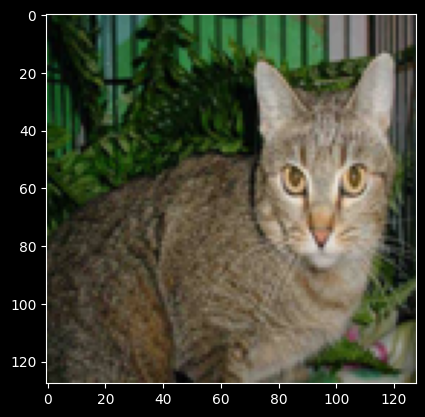

In [50]:
image = Image.open('datasets/DVC/cat.1120.jpg')
shape = configuration['shape']
image = image.resize(shape[:2])
plt.imshow(image)
image = np.array(image)
images = [image,]*10
images = np.array(images,dtype = 'float64')
print(images.shape)

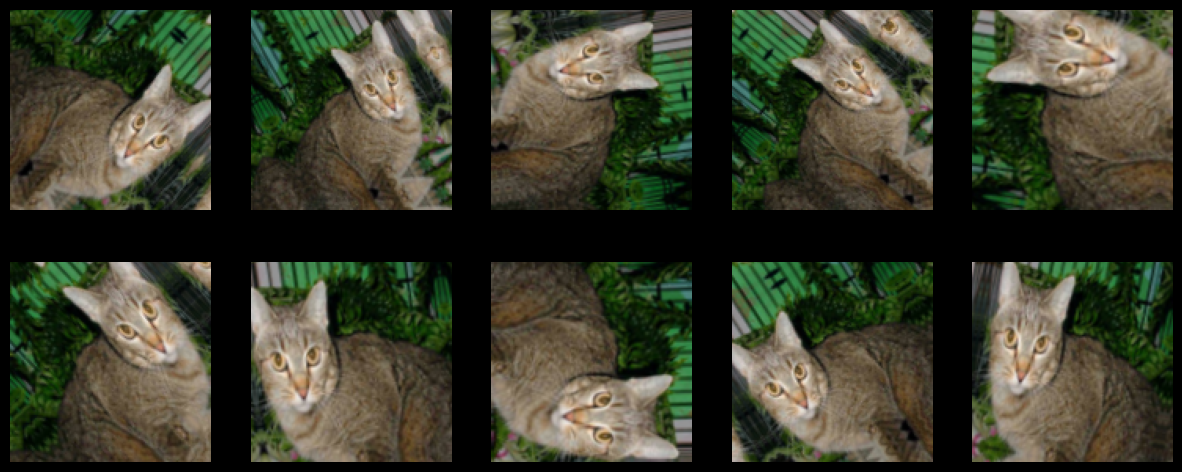

In [56]:
shape = configuration['shape']
aug_model = get_Augment(shape)
out_images = aug_model(images)
display_images(out_images,grid=(2,5),size = 3)

In [148]:
def Build_Model():
    shape = configuration['shape']
    activ = configuration['activation']
    n_class = configuration['n_class']
    
    aug_model = get_Augment(shape)
    fn_input = Input(shape)
    x = aug_model(fn_input)
    
    x = BatchNormalization()(x)
    
    x = Conv2D(filters = 32
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,use_bias= False
               ,activation = None
              )(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = MaxPool2D(pool_size=2,strides = 2)(x)


    x = Conv2D(filters = 32
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,activation = None
               ,use_bias= False
              )(x)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    x = MaxPool2D(pool_size=2,strides = 2)(x)


    x = Conv2D(filters = 64               
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,use_bias= False
               ,activation = None
               ,dilation_rate = 2 
              )(x)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    x = MaxPool2D(pool_size=2,strides = 2)(x)

    
    x = Conv2D(filters = 64
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,activation = None
               ,use_bias = False
               ,dilation_rate = 2 
              )(x)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    x = MaxPool2D(pool_size=2,strides = 2)(x)

    x = Conv2D(filters = 128
               ,kernel_size = 3
               ,strides = 1
               ,padding = 'same'
               ,activation = activ
               ,use_bias = False
               ,dilation_rate = 3
              )(x)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    
    x = GlobalAveragePooling2D()(x)

    x = Dense(64,activation= activ)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(24,activation= activ)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(8,activation= activ)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    if(n_class > 2):
        x = Dense(n_class , activation = 'softmax')(x)
    else:
        x = Dense(1 , activation = 'sigmoid')(x)
            
    my_model = Model(fn_input,x)
    my_model.name = 'My_Model'
    return my_model

In [149]:
my_model = Build_Model()
my_model.summary()

Model: "My_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_model (Functional)          │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 64, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 8, 8, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 8, 8, 128)      │             

 Total params: 150,805 (589.08 KB)

 Trainable params: 149,967 (585.81 KB)

 Non-trainable params: 838 (3.27 KB)

## Training Model 

In [150]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,CSVLogger

In [151]:
plateau_callback = ReduceLROnPlateau(
                        monitor= 'val_loss'
                        ,min_delta = 0
                        ,factor = 0.6
                        ,cooldown = 1
                        ,verbose = 1
                        ,min_lr = 10^(-5)
                        ,patience = 7
)

try:
    os.makedirs('Models/')
except:
    pass
    
model_path = 'Models/'+ 'my_model' +'.weights.h5'
checkpoint_callback = ModelCheckpoint(
                    filepath = model_path
                    ,monitor = 'val_loss'
                    ,verbose = 1
                    ,initial_value_threshold = 0.5
                    ,save_best_only = True
                    ,save_weights_only = True
)
 
try:
    os.makedirs('Models_Logs/')
except:
    pass
    
model_log_path = "Models_Logs/" + "my_model" + '_log.csv'
log_callback = CSVLogger(
        filename = model_log_path,
        append = True,
)

In [152]:
lr = configuration['lr']
my_model.compile(
    optimizer = Adam(lr),
    loss=BinaryCrossentropy(),
    metrics = ['accuracy',]
)    

In [153]:
n_epoch = configuration['n_epoch']
# n_epoch = 10
history = my_model.fit(
    train_Data,
    validation_data = val_Data,
    epochs = n_epoch,
    verbose = 1,
    callbacks= [checkpoint_callback
                ,plateau_callback
                ,log_callback
               ]
)

Epoch 1/80
1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5393 - loss: 0.7229
Epoch 1: val_loss did not improve from 0.50000
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - accuracy: 0.5393 - loss: 0.7229 - val_accuracy: 0.5015 - val_loss: 0.8102 - learning_rate: 0.0050
Epoch 2/80
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5994 - loss: 0.6660
Epoch 2: val_loss did not improve from 0.50000
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.5994 - loss: 0.6660 - val_accuracy: 0.5870 - val_loss: 0.6713 - learning_rate: 0.0050
Epoch 3/80
1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6248 - loss: 0.6497
Epoch 3: val_loss did not improve from 0.50000
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.6248 - loss: 0.6497 - val_accuracy: 0.6490 - val_loss: 0.6179 - learning_rate: 0.0050
Epoch 4/80
1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6474 - loss: 0.6283
Epoch 4: val_loss did not improve from 0.50000
1125/1125 ━━━━━━━━━━━

In [159]:
my_model.load_weights(model_path)
History = pd.read_csv(model_log_path)[['loss'
                                       ,'val_loss'
                                       ,'accuracy'
                                       ,'val_accuracy'
                                       ,'learning_rate'
                                      ]]
History.iloc[-5:]

,loss,val_loss,accuracy,val_accuracy,learning_rate
75,0.222589,0.437028,0.910333,0.9195,0.000648
76,0.218063,0.232384,0.915444,0.9250,0.000648
77,0.216936,0.286212,0.912333,0.9210,0.000648
78,0.217309,0.288754,0.913500,0.9255,0.000648
79,0.216999,0.217284,0.913389,0.9230,0.000648


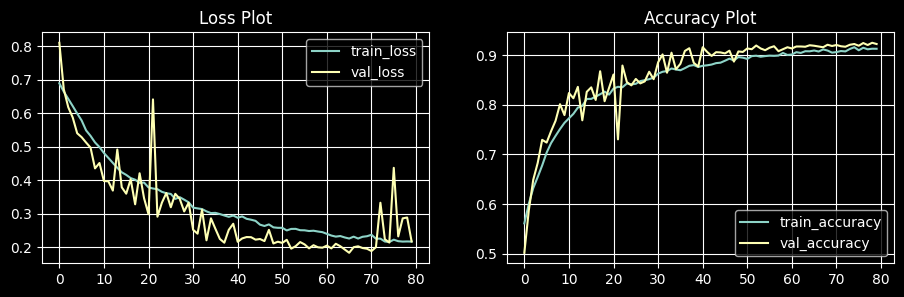

In [163]:
plt.figure(figsize=(11,3))

plt.subplot(1,2,1)
plt.plot(History['loss'],label = 'train_loss')
plt.plot(History['val_loss'],label = 'val_loss')
plt.grid()
plt.legend()
plt.title("Loss Plot")

plt.subplot(1,2,2)
plt.plot(History['accuracy'],label = 'train_accuracy')
plt.plot(History['val_accuracy'],label = "val_accuracy")
plt.grid()
plt.legend()
plt.title("Accuracy Plot")
plt.show()

Text(0.5, 1.0, 'Learning Rate Plot')

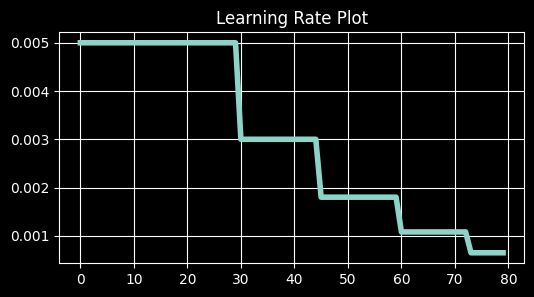

In [167]:
plt.figure(figsize=(6,3))
plt.plot(History['learning_rate'],linewidth = 4)
plt.grid()
plt.title("Learning Rate Plot")

## Evaluating Model

In [156]:
Y_pred = my_model.predict(X_test)
Y_pred = Y_pred>=0.5

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


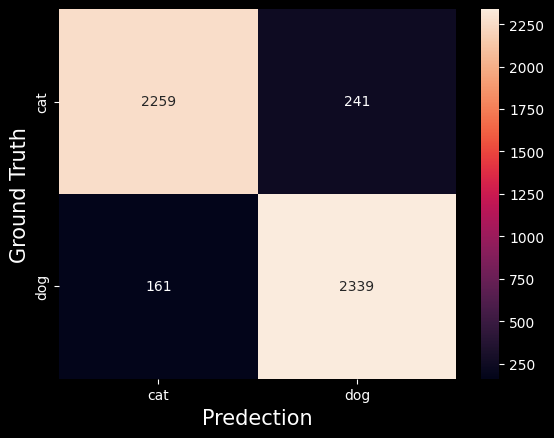

,cat,dog,accuracy,macro avg,weighted avg
precision,0.933471,0.906589,0.9196,0.920030,0.920030
recall,0.903600,0.935600,0.9196,0.919600,0.919600
f1-score,0.918293,0.920866,0.9196,0.919579,0.919579
support,2500.000000,2500.000000,0.9196,5000.000000,5000.000000


In [157]:
def show_Confusion_Matrix(Y_test_,Y_pred_):
    matrix = np.asarray(tf.math.confusion_matrix(Y_test_,Y_pred_))
    sn.heatmap(matrix,annot=True,fmt = ".0f",
               xticklabels=classes ,yticklabels= classes,
              )
    plt.ylabel("Ground Truth",fontsize = 15)
    plt.xlabel("Predection",fontsize = 15)
    plt.show()

show_Confusion_Matrix(Y_test,Y_pred)

from sklearn.metrics import classification_report
report = classification_report(Y_test,Y_pred , output_dict= True,target_names= classes)
pd.DataFrame(report)

In [158]:
# os.remove(model_log_path)
# os.remove(model_path)